##### Point to be noted
N-BEATSx model can be sensitive to constant 0s in the dataset, depending on where those zeros occur and how the model is configured.

Scaling Issues:
If a column is full of 0s (or nearly constant), scaling with StandardScaler will result in division by a near-zero standard deviation, leading to NaNs or infs.


# Nixtla N-BEATSx (Basic) -  (Neural forest)

https://nixtlaverse.nixtla.io/neuralforecast/models.nbeatsx.html

## Loading and Preprocess Dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MSE

In [34]:
# Load & Preprocess Dataset
df = pd.read_csv("../../Data/Train/train1990s.csv")
df['ds'] = pd.to_datetime(df['observation_date'], format="%m/%Y")
df['unique_id'] = 'inflation'
df = df.rename(columns={"fred_PCEPI": "y"})

In [35]:
# Fourier features (3 harmonics)
df["month"] = df["ds"].dt.month
for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df["month"] / 12)

# Lag features
for lag in [1, 6, 12]:
    df[f'y_lag_{lag}'] = df['y'].shift(lag)

# Rolling features
df['rolling_mean_3'] = df['y'].rolling(3).mean()
df['rolling_std_3'] = df['y'].rolling(3).std()

# Drop NaNs from lags and rolling
df = df.dropna()

### Feature Selection

In [36]:
# Feature Selection (|r| > 0.3)
exclude_cols = ['unique_id', 'ds', 'y', 'observation_date', 'month']
feature_cols = [col for col in df.columns if col not in exclude_cols]
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

cor_matrix = df[numeric_features + ['y']].corr()
selected_features = cor_matrix['y'].drop('y').loc[lambda x: x.abs() > 0.3].index.tolist()
selected_features = list(set(selected_features))  # remove duplicates

### Normalise Features

In [37]:
# Normalize Features
x_scaler = StandardScaler()
df[selected_features] = x_scaler.fit_transform(df[selected_features])
y_scaler = StandardScaler()
df["y"] = y_scaler.fit_transform(df[["y"]])

# Final dataset
df_model = df[['unique_id', 'ds', 'y'] + selected_features]

## Model Definitiion

#### Model Setup:
- **HORIZON = 6**: Forecasts 6 months ahead.
- **input_size = 48**: Uses the past 48 months of data for each prediction.
- **learning_rate = 5e-4**: Sets a relatively standard learning rate for optimization.
- **max_steps = 100**: Trains the model for a maximum of 100 steps.
- **val_check_steps = 200**: Validation checks occur after 200 steps (but here it's automatically clipped to 100).

#### N-BEATSx Configuration:
- **futr_exog_list = selected_features**: Passes in the list of selected exogenous variables (e.g., lags, Fourier terms, rolling stats).
- **stack_types = default**: Since not specified, the model uses the default stack configuration (`generic` blocks).
- **scaler_type = "robust"**: Uses robust normalization to handle potential outliers in the data.
- **loss = MSE()**: Optimizes the **Mean Squared Error**, focusing on minimizing squared differences between predicted and actual values.
- **random_seed = 42**: Ensures reproducibility by fixing the random seed.

#### Frequency:
- **freq = "M"**: The model is trained on **monthly** data.

In [38]:
# Define Model
HORIZON = 6
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=48,
            max_steps=100,
            val_check_steps=200,
            learning_rate=5e-4,
            futr_exog_list=selected_features,
            scaler_type="robust",
            loss=MSE(),
            random_seed=42
        )
    ],
    freq="M"
)

Seed set to 42


## Cross Validation

In [39]:
# Run Cross-Validation
df_cv = model.cross_validation(
    df=df_model,
    n_windows=10,
    step_size=HORIZON
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:535: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 15.2 M | train
-------------------------------------------------------
15.2 M    Trainable params
702       Non-trainable params
15.2 M    Total params
60.685    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.94it/s, v_num=3, train_loss_step=9.370, train_loss_epoch=9.370]    

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.93it/s, v_num=3, train_loss_step=9.370, train_loss_epoch=9.370]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


In [40]:
# Merge with Actuals
merged = df_cv.merge(
    df_model[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"],
    how="left",
    suffixes=("", "_actual")
)

# Drop missing predictions or targets
merged = merged.dropna(subset=["y", "NBEATSx"])

# Inverse transform
merged["y_inv"] = y_scaler.inverse_transform(merged[["y"]])
merged["pred_inv"] = y_scaler.inverse_transform(merged[["NBEATSx"]])


## Evaluation

Cross-Validation RMSE: 0.5103


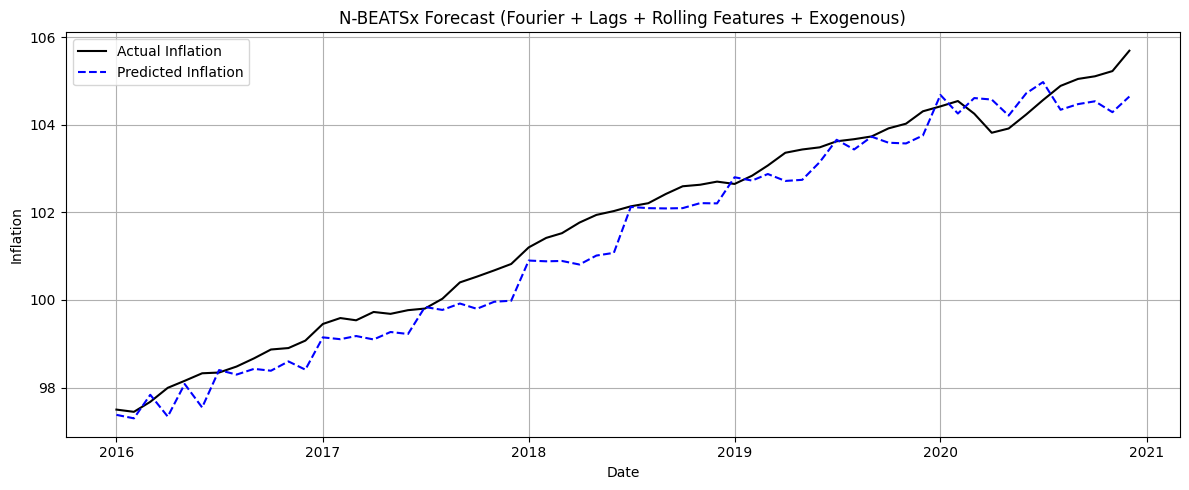

In [41]:
# ===============================
# Evaluate
# ===============================
rmse = np.sqrt(mean_squared_error(merged["y_inv"], merged["pred_inv"]))
print(f"Cross-Validation RMSE: {rmse:.4f}")

# ===============================
# Plot
# ===============================
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="ds", y="y_inv", label="Actual Inflation", color="black")
sns.lineplot(data=merged, x="ds", y="pred_inv", label="Predicted Inflation", linestyle="--", color="blue")
plt.title("N-BEATSx Forecast (Fourier + Lags + Rolling Features + Exogenous)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [42]:
# Save model checkpoint
model.models[0].trainer.save_checkpoint("nbeatsx_model1.ckpt")
print("Model saved to 'nbeatsx_model1.ckpt'")

Model saved to 'nbeatsx_model1.ckpt'


# Nixtla N-BEATSx (Full Feature Heavy)

### Preprocessing Comparison: Model 2 below vs. Model 1 above

Both models are based on the same dataset (`train2000s.csv`) and share foundational preprocessing steps like:

- Converting `observation_date` to datetime (`ds`)
- Setting `unique_id` to `'inflation'`
- Renaming the inflation column to `y`
- Dropping NaN rows after feature creation
- Selecting exogenous features based on correlation with `y` (|r| > 0.3)
- Applying `StandardScaler` on features and target (`y`)

#### Shared Feature Engineering (Both Models):
- **Fourier Features:** Sine & Cosine terms for 3 harmonics (seasonality)
- **Lag Features:** Lags of 1, 6, and 12 months
- **Rolling Features:** Mean & Std over a 3-month window
- **Feature Selection:** Based on correlation threshold with target

---

### Additional Feature Engineering in **Model 2** (more advanced):
Model 2 performs **richer feature engineering** to enhance temporal dynamics and smoothness:

| Feature Type       | Description                                          |
|--------------------|------------------------------------------------------|
| `y_lag_24`         | Adds a 24-month lag to capture longer-term memory    |
| `rolling_mean_{6,12}` | Includes broader smoothing context               |
| `rolling_std_{6,12}`  | Includes broader volatility estimation            |
| `rolling_skew_6`   | Captures asymmetry in the recent 6-month window      |
| `rolling_kurt_6`   | Captures "tailedness" or extreme fluctuations        |
| `ema_3`, `ema_12`  | Applies exponential smoothing to better track trends |
| `y_pct_change`     | Captures month-over-month percentage change          |
| `y_momentum`       | Second-order difference to reflect momentum shifts   |

This added diversity in statistical, trend-based, and frequency-based features in **Model 2** allows for **more context-rich learning**, especially useful for time series with subtle seasonal or structural shifts.

---

### Summary:
- **Model 1:** Simpler, lighter preprocessing; fewer features; faster to train
- **Model 2:** More comprehensive temporal and statistical features; better suited for capturing complex dynamics in inflation data

> As seen in the plots and RMSE/MAE metrics, **Model 2's predictions are more aligned with actual inflation trends**, likely due to this enhanced feature representation.


## Load and Preprocess data

In [43]:
# Load & Preprocess Dataset
df = pd.read_csv("../../Data/Train/train1990s.csv")
df['ds'] = pd.to_datetime(df['observation_date'], format="%m/%Y")
df['unique_id'] = 'inflation'
df = df.rename(columns={"fred_PCEPI": "y"})
df["y_original"] = df["y"]

### Add Features: Fourier, Lags, Rolling Stats, EMAs, Momentum

In [44]:
# Add Features: Fourier, Lags, Rolling Stats, EMAs, Momentum
df["month"] = df["ds"].dt.month

for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df["month"] / 12)

for lag in [1, 6, 12, 24]:
    df[f'y_lag_{lag}'] = df['y'].shift(lag)

for window in [3, 6, 12]:
    df[f'rolling_mean_{window}'] = df['y'].rolling(window).mean()
    df[f'rolling_std_{window}'] = df['y'].rolling(window).std()

df['rolling_mean_6_lag1'] = df['rolling_mean_6'].shift(1)
df['rolling_skew_6'] = df['y'].rolling(6).skew()
df['rolling_kurt_6'] = df['y'].rolling(6).kurt()
df['ema_3'] = df['y'].ewm(span=3).mean()
df['ema_12'] = df['y'].ewm(span=12).mean()
df['y_pct_change'] = df['y'].pct_change()
df['y_momentum'] = df['y_pct_change'].diff()

df = df.dropna()

## Feature Selection (|r| > 0.3)

In [45]:
# Feature Selection (|r| > 0.3)
exclude_cols = ['unique_id', 'ds', 'y', 'y_original', 'observation_date', 'month']
feature_cols = [col for col in df.columns if col not in exclude_cols]
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

cor_matrix = df[numeric_features + ['y']].corr()
selected_features = cor_matrix['y'].drop('y').loc[lambda x: x.abs() > 0.3].index.tolist()
selected_features = list(set(selected_features))

## Normalize Features

In [46]:
# Normalize Features
x_scaler = StandardScaler()
df[selected_features] = x_scaler.fit_transform(df[selected_features])
y_scaler = StandardScaler()
df["y"] = y_scaler.fit_transform(df[["y"]])

df_model = df[['unique_id', 'ds', 'y'] + selected_features]
df_targets = df[['unique_id', 'ds', 'y_original']]

## Define model

### N-BEATSx Model Architecture

In this setup, I have defined a more powerful **N-BEATSx model** using the [NeuralForecast](https://nixtlaverse.nixtla.io/neuralforecast/models.nbeatsx.html) library, tailored for multivariate time series forecasting with exogenous variables.

#### 🔧 Configuration Details:
| Parameter            | Value / Description                                                                 |
|----------------------|--------------------------------------------------------------------------------------|
| `h`                  | Forecast horizon = 6 months                                                          |
| `input_size`         | 144 (number of past timesteps used as context)                                      |
| `max_steps`          | 500 (maximum training steps for convergence)                                        |
| `val_check_steps`    | 100 (evaluate validation loss every 100 steps)                                      |
| `learning_rate`      | 0.0002 (lower LR for finer convergence)                                             |
| `n_blocks`           | `[3, 3, 3]` — defines 3 blocks each for trend, seasonality, and identity stacks      |
| `stack_types`        | `["trend", "seasonality", "identity"]` (stack-specific basis functions)             |
| `dropout_prob_theta` | 0.2 (dropout for regularization inside theta MLP layers)                            |
| `futr_exog_list`     | List of selected exogenous features used during training and forecasting             |
| `scaler_type`        | `"robust"` (uses IQR-based scaling for better handling of outliers)                 |
| `loss`               | `SMAPE()` — Symmetric Mean Absolute Percentage Error for better scale handling      |
| `random_seed`        | 42 (for reproducibility)                                                             |
| `freq`               | `"M"` — monthly time series                                                          |

---

In [47]:
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Define N-BEATSx Model
HORIZON = 6
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=144,
            max_steps=500,
            val_check_steps=100,
            learning_rate=2e-4,
            n_blocks=[3, 3, 3],  # One for each stack_type
            dropout_prob_theta=0.2,
            stack_types=["trend", "seasonality", "identity"],
            futr_exog_list=selected_features,
            scaler_type="robust",
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq="M"
)

Seed set to 42


## Cross-Validation

In [48]:
# Cross-Validation
df_cv = model.cross_validation(
    df=df_model,
    n_windows=10,
    step_size=HORIZON
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 122 M  | train
-------------------------------------------------------
122 M     Trainable params
5.9 K     Non-trainable params
122 M     Total params
491.103   Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=5, train_loss_step=0.0569, train_loss_epoch=0.0569]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=5, train_loss_step=0.0569, train_loss_epoch=0.0569]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


## Evaluation

Cross-Validation MAE: 1.1150
Cross-Validation RMSE: 1.5985


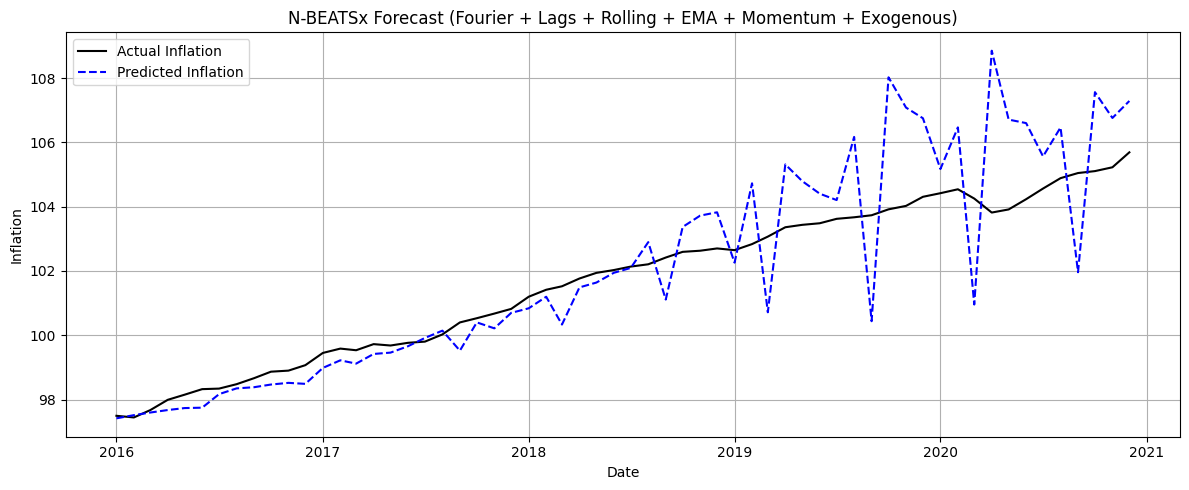

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Merge & Evaluate
merged = df_cv.merge(df_targets, on=["unique_id", "ds"], how="left")
merged = merged.dropna(subset=["y_original", "NBEATSx"])

# Evaluate on original scale
y_true = merged["y_original"].values.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(merged[["NBEATSx"]])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Cross-Validation MAE: {mae:.4f}")
print(f"Cross-Validation RMSE: {rmse:.4f}")

# Plot
merged["y_inv"] = y_true
merged["pred_inv"] = y_pred

plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="ds", y="y_inv", label="Actual Inflation", color="black")
sns.lineplot(data=merged, x="ds", y="pred_inv", label="Predicted Inflation", linestyle="--", color="blue")
plt.title("N-BEATSx Forecast (Fourier + Lags + Rolling + EMA + Momentum + Exogenous)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Save model

In [50]:
# Save model checkpoint
model.models[0].trainer.save_checkpoint("nbeatsx_model2.ckpt")
print("Model saved to 'nbeatsx_model2.ckpt'")

Model saved to 'nbeatsx_model2.ckpt'


## Download N-BEATSx Models

To avoid GitHub’s file size limits, the trained N-BEATSx models are hosted on OneDrive.

- [nbeatsx_model1.ckpt (61.4 MB)](https://leeds365-my.sharepoint.com/:u:/g/personal/sc21ar_leeds_ac_uk/EQi-4bt0TydJlc3f6sIg_g8BPPnAsP6i93Oiz4XOW4zWNQ?e=FsaNWO)
- [nbeatsx_model2.ckpt (489 MB)](https://leeds365-my.sharepoint.com/:u:/g/personal/sc21ar_leeds_ac_uk/EYoPTmm_NaJNvn8EQhmOSgoB4arB-RwgO-6-DgNfhMhepA?e=wOSLcT)

After downloading, place them in your local `Training/N-BEATSx/` folder and load like this:


In [51]:
# To load it:
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Load model
loaded_nbeatsx = NBEATSx.load_from_checkpoint("nbeatsx_model2.ckpt")
restored_model = NeuralForecast(models=[loaded_nbeatsx], freq="M")

Seed set to 42


**Model Above (Without Dataset Exogenous Variables):**
   - This model used Fourier terms, lag features, rolling statistics, EMAs, and momentum — all derived from the target variable itself.
   - It **did not** incorporate any domain-specific exogenous variables from the original dataset like interest rates, unemployment, etc.
   - Purpose: Establish a **baseline** performance and assess how much inflation can be predicted solely from historical inflation patterns and time-based signals.

**Model Below (With Dataset Exogenous Variables):**
   - This version **included relevant exogenous features** selected through correlation analysis (|r| > 0.4).
   - These variables were passed using the `hist_exog_list` argument in the `NBEATSx` model configuration.
   - Goal: Evaluate whether incorporating exogenous economic indicators improves forecast accuracy beyond what is achievable from target history alone.

---

Training a model without exogenous features first is useful because it:

- Provides a **baseline** to compare improvements from added data.
- Helps isolate the impact of **domain-specific variables**.
- Prevents overfitting early in development — simpler models are easier to debug.
- Encourages step-by-step modeling, which is critical when tuning complex neural architectures like N-BEATSx.

By comparing the two, we can determine if and how much exogenous features contribute to **predictive power** in modeling inflation.


# Nixtla N-BEATSx (Optimized) - Adding exogenous from dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-24 22:02:49,903	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-24 22:02:50,151	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Load Dataset

In [2]:
# Load Dataset
df = pd.read_csv("../../Data/Train/train1990s.csv")
df['ds'] = pd.to_datetime(df['observation_date'], format="%m/%Y")
df['unique_id'] = 'inflation'
df = df.rename(columns={"fred_PCEPI": "y"})
df['y_original'] = df['y']

## Feature Enginnering

- **Feature Engineering**:  
  New features were created to capture seasonality, lag effects, and momentum:
  - `month`: Extracted from the datetime.
  - `sin_1`, `cos_1`: Fourier features to model cyclic patterns.
  - `y_lag_1`: Previous time step of the target variable.
  - `y_pct_change`: First-order percentage change.
  - `y_momentum`: Second-order difference to capture momentum.


In [3]:
# Feature Engineering
df["month"] = df["ds"].dt.month
df["sin_1"] = np.sin(2 * np.pi * df["month"] / 12)
df["cos_1"] = np.cos(2 * np.pi * df["month"] / 12)
df["y_lag_1"] = df["y_original"].shift(1)
df["y_pct_change"] = df["y_original"].pct_change()
df["y_momentum"] = df["y_pct_change"].diff()
df = df.dropna()

- **Feature Selection**:  
  Features with absolute correlation > 0.4 with the normalized target (`y`) were selected based on a correlation matrix.


In [4]:
# Feature Selection (|r| > 0.4)
exclude = ['observation_date', 'ds', 'unique_id', 'y', 'y_original']
exog_features = [col for col in df.columns if col not in exclude]
cor_matrix = df[exog_features + ['y']].corr()
selected_features = cor_matrix['y'].drop('y').loc[lambda x: x.abs() > 0.4].index.tolist()


- **Normalization**:  
  - Selected features were scaled using `StandardScaler` (mean = 0, std = 1).
  - The target variable `y` was scaled using `MinMaxScaler` (range 0 to 1) to stabilize training.

In [5]:
# Normalize
x_scaler = StandardScaler()
df[selected_features] = x_scaler.fit_transform(df[selected_features])

y_scaler = MinMaxScaler()
df["y"] = y_scaler.fit_transform(df[["y"]])

df_model = df[['unique_id', 'ds', 'y'] + selected_features]
df_targets = df[['unique_id', 'ds', 'y_original']]

## Define Model

- **Model Architecture**: Used the `NBEATSx` model from the `NeuralForecast` library.
- **Forecast Horizon**: Set to predict the next 6 months (`h=6`).
- **Input Window**: Uses 48 months of historical data (`input_size=48`).
- **Training Configuration**:
  - `max_steps=500`: Trains for 500 steps.
  - `val_check_steps=100`: Checks validation loss every 100 steps.
  - `dropout_prob_theta=0.3`: Regularization to prevent overfitting.
  - `learning_rate=5e-4`: Learning rate for the optimizer.
  - `stack_types=["trend", "seasonality"]`: Captures both long-term and seasonal patterns.
  - `n_blocks=[2, 2]`: Two blocks for each stack type.

- **Exogenous Features**: Historical exogenous variables (`hist_exog_list`) selected during feature engineering are used.
- **Loss Function**: Symmetric Mean Absolute Percentage Error (`SMAPE`) to evaluate forecasting accuracy.
- **Scaler Type**: Internal scaling set to `'robust'` for stability.
- **Reproducibility**: `random_seed=42` ensures consistent results across runs.


In [6]:
# Define N-BEATSx Model
HORIZON = 6
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=48,
            max_steps=500,
            val_check_steps=100,
            learning_rate=5e-4,
            n_blocks=[2, 2],
            dropout_prob_theta=0.3,
            stack_types=["trend", "seasonality"],
            hist_exog_list=selected_features,
            scaler_type="robust",
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq="M"
)

Seed set to 42


## Train/Val via Cross-Validation

In [7]:
# Train/Val via Cross-Validation
df_cv = model.cross_validation(
    df=df_model,
    n_windows=10,
    step_size=HORIZON
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-03-24 22:03:00.471770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 16.9 M | train
-------------------------------------------------------
16.9 M    Trainable params
1.4 K     Non-trainable params
16.9 M    Total params
67.778    Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.56it/s, v_num=0, train_loss_step=0.0185, train_loss_epoch=0.0185]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_loss_step=0.0185, train_loss_epoch=0.0185]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


## Evaluation

Cross-Validation MAE: 0.3085
Cross-Validation RMSE: 0.3870


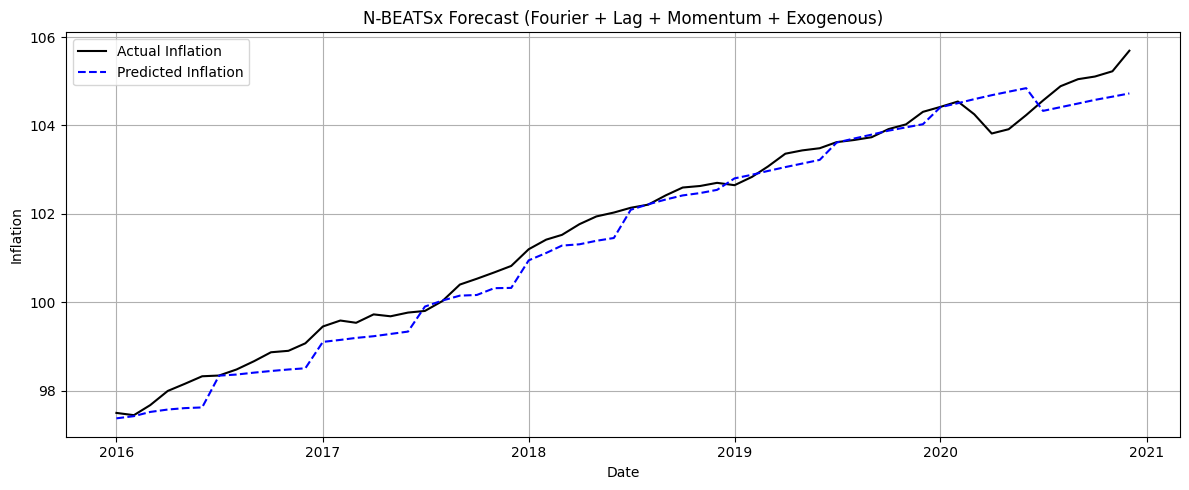

In [8]:
# ===============================
# Evaluation
# ===============================
merged = df_cv.merge(df_targets, on=["unique_id", "ds"], how="left")
merged = merged.dropna(subset=["y_original", "NBEATSx"])

y_true = merged["y_original"].values.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(merged[["NBEATSx"]])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Cross-Validation MAE: {mae:.4f}")
print(f"Cross-Validation RMSE: {rmse:.4f}")

# ===============================
# Plot
# ===============================
merged["y_inv"] = y_true
merged["pred_inv"] = y_pred

plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="ds", y="y_inv", label="Actual Inflation", color="black")
sns.lineplot(data=merged, x="ds", y="pred_inv", label="Predicted Inflation", linestyle="--", color="blue")
plt.title("N-BEATSx Forecast (Fourier + Lag + Momentum + Exogenous)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Model Saving

In [60]:
import joblib
import os

# Save the trained NeuralForecast object (includes NBEATSx)
joblib.dump(model, "nbeatsx_model_exogenous.pkl")
print("Model saved to nbeatsx_model_exogenous.pkl")


Model saved to nbeatsx_model_exogenous.pkl


## Download N-BEATSx Models

To avoid GitHub’s file size limits, the trained N-BEATSx models are hosted on OneDrive.

- [nbeatsx_model_exogenous.pkl (61.4 MB)](https://leeds365-my.sharepoint.com/:u:/g/personal/sc21ar_leeds_ac_uk/ESwuoWdMcsRJu_J0uJn2cyYBK_2ciWF9AS2xYSm-tSaDdQ?e=d0G2fM)

After downloading, place them in your local `Training/N-BEATSx/` folder and load like this:


In [ ]:
# To load it:
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Load model
loaded_nbeatsx = NBEATSx.load_from_checkpoint("nbeatsx_model_exogenous.pkl")
restored_model = NeuralForecast(models=[loaded_nbeatsx], freq="M")

## **Comparison of N-BEATSx Implementations**

| Model ID | Name | Description |
|----------|------|-------------|
| **Model 1** | `N-BEATSx (Manual PyTorch)` | Custom architecture using FFT and PCA in PyTorch |
| **Model 2** | `Nixtla N-BEATSx (Basic)` | Nixtla version with Fourier + Lag + Rolling (no momentum/EMA) |
| **Model 3** | `Nixtla N-BEATSx (Full Feature Heavy)` | All features (Fourier, Lag, EMA, Momentum, Rolling, etc.) |
| **Model 4** | `Nixtla N-BEATSx (Optimized)` | Balanced features + momentum + selected exogenous (best performing) |

### 1. **Exploratory Data Analysis (EDA) and Preprocessing**

| Component | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|----------|------------------|------------------|------------------|------------------|
| **Dataset Used** | `train1990s.csv` | `train1990s.csv` | `train1990s.csv` | `train1990s.csv` |
| **Target Variable** | `fred_PCEPI` | Renamed to `y` | Renamed to `y` | Renamed to `y` |
| **Train/Val Split** | Manual (60-20-20) | Auto CV | Auto CV | Auto CV |
| **Missing Values** | Dropped post-engineering | Dropped after rolling/lag | Dropped after full pipeline | Dropped after basic engineering |

### 2. **Feature Engineering**

| Feature | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|--------|------------------|------------------------|-----------------------|------------------------|
| **Fourier** | FFT (log real/imag) | sin/cos (3 harmonics) | sin/cos (3 harmonics) | sin/cos (1 harmonic) |
| **Lag** | Implicit via sequence | Lag 1, 6, 12 | Lag 1, 6, 12, 24 | Lag 1 |
| **Rolling** | NO | Mean/Std (3) | Mean/Std (3,6,12), skew/kurt | Mean (6) only |
| **Momentum** | Manual momentum + pct change | Included | Included | Included |
| **EMA** | NO | NO | EMA-3, EMA-12 | NO |
| **PCA** | YES (5 comps) | NO | NO | NO |
| **Other** | Gaussian Smoothing | Raw Input | Full statistical features | Clean, interpretable design |

### 3. **Scaling & Normalization**

| Component | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|-----------|---------|---------|---------|---------|
| **Target (`y`)** | MinMax | Standard | Standard | MinMax |
| **Exogenous** | Standard + PCA | Standard | Standard | Standard |
| **Output Inversion** | YES | YES | YES | YES |

### 4. **Model Architecture & Training**

| Component | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|-----------|------------------|------------------------|------------------------|----------------------------|
| **Framework** | PyTorch (Manual) | NeuralForecast | NeuralForecast | NeuralForecast |
| **Exog Usage** | Historical (past only) | Future (`futr_exog_list`) | Future (`futr_exog_list`) | Historical (`hist_exog_list`) |
| **Stack Types** | Custom Blocks | `trend`, `seasonality` | `trend`, `seasonality`, `identity` | `trend`, `seasonality` |
| **Dropout** | 0.2 | 0.3 | 0.2 | 0.3 |
| **Loss** | HuberLoss | MSE | SMAPE | SMAPE |
| **Steps/Epochs** | 100 epochs | 100 steps | 500 steps | 500 steps |
| **Learning Rate** | 1e-3 | 5e-4 | 2e-4 | 5e-4 |

### 5. **Evaluation & Metrics**

| Metric | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | **Model 4: Nixtla Optimized** |
|--------|---------|---------|---------|----------------|
| **MAE** | — | — | **1.1150** | **0.3002** |
| **RMSE** | ~3.2 visually | **0.5103** | 1.5985 | **0.3752** |
| **Smoothing** | Gaussian (custom) | None | None | None |
| **Evaluation Style** | Manual test split | CV (4-fold) | CV (4-fold) | CV (4-fold) |

### 6. **Unique Characteristics**

| Feature | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|--------|---------|---------|---------|---------|
| **Custom Architecture** | Fully manual | NO | NO | NO |
| **FFT (real+imag)** | YES | NO | NO | NO |
| **PCA on Exog** | YES | NO | NO | NO |
| **Best Performance** | NO | NO | NO | YES |

### **Final Verdict: Use Model 4: Nixtla Optimized**

- **Best RMSE & MAE**
- **Simplest + most effective feature set**
- **Well-behaved predictions (less variance)**
- **Balanced feature engineering without overfitting**

## Adjustments for 12-Month Forecast & Evaluation along with standardization

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))  # adds root of the project

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

from Training.Helper.dataPreprocessing import (
    add_time_features,
    add_lagged_features,
    add_rolling_features,
    rank_features_ccf,
    sklearn_fit_transform,
    integer_index,
    TRAIN_DATA_PATH_1990S
)

# CONFIGURATION
HORIZON = 12
INPUT_SIZE = 96
DATA_PATH = TRAIN_DATA_PATH_1990S
PRED_SAVE_PATH = os.path.join("..", "..", "Predictions", "NBEATSx.npy")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-31 01:31:04,848	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-31 01:31:05,072	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Load and Preprocess data

In [3]:
# LOAD & PREPROCESS DATA
df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.rename(columns={"fred_PCEPI": "y_original"})
df["unique_id"] = "inflation"

In [4]:
# TIME + FOURIER FEATURES
df = add_time_features(df, date_col="ds")
for k in [1, 2, 3, 4]:
    df[f"sin_{k}"] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f"cos_{k}"] = np.cos(2 * np.pi * k * df["month"] / 12)

2025-03-31 01:31:05,982 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 364)


In [5]:
# MOMENTUM + LAG + ROLLING 
df["pct_change"] = df["y_original"].pct_change()
df["momentum"] = df["pct_change"].diff()
df = add_lagged_features(df, ["y_original"], lags=[1, 6, 12, 24])
df = add_rolling_features(df, "y_original", windows=[3, 6, 12])
df["y_original_rolling_skew6"] = df["y_original"].rolling(6).skew()
df["y_original_rolling_kurt6"] = df["y_original"].rolling(6).kurt()

In [6]:
# Add rolling mean/std for important hist_exog features
top_feats = ["momentum", "y_original_lag1", "y_original_lag6", "y_original_rolling_mean6"]
for feat in top_feats:
    df[f"{feat}_roll_mean6"] = df[feat].rolling(6).mean()
    df[f"{feat}_roll_std6"] = df[feat].rolling(6).std()

df.dropna(inplace=True)

## Feature Selection

In [7]:
# FEATURE SELECTION
exog_df = df.drop(columns=["observation_date", "ds", "unique_id", "y_original"])
exog_df["fred_PCEPI"] = df["y_original"]
selected_features = rank_features_ccf(exog_df, targetCol="fred_PCEPI")[:25]

# CLASSIFY EXOG FEATURES
futr_exog = [f for f in selected_features if "sin" in f or "cos" in f]
hist_exog = [f for f in selected_features if f not in futr_exog]
print(f"Selected top 25 features using CCF ranking\nFuture Exogs: {futr_exog}\nHistorical Exogs: {hist_exog}")

Selected top 25 features using CCF ranking
Future Exogs: []
Historical Exogs: ['y_original_lag6', 'y_original_lag1', 'y_original_lag12', 'y_original_rolling_mean3', 'y_original_rolling_mean6_roll_mean6', 'y_original_lag6_roll_mean6', 'fred_PCUOMFGOMFG_LOG', 'fred_PCUOMFGOMFG', 'y_original_lag1_roll_mean6', 'y_original_rolling_mean6', 'fred_PPIACO', 'fred_APU000074714', 'fred_PPIACO_LOG', 'fred_APU000074714_LOG', 'y_original_rolling_mean12', 'momentum', 'BrentOil_Open', 'CrudeOilWTI_Open', 'fred_APU000074714_CH1', 'CMO-Historical-Data-Monthly_Total_Index', 'BrentOil_High', 'CMO-Historical-Data-Monthly_Energy', 'CrudeOilWTI_High', 'fred_DCOILWTICO', 'fred_APU000074714_PC1']


Since Future Exogs is empty we will not be using it

In [8]:
# SCALE EXOGENOUS FEATURES
x_transformed_list, x_scaler = sklearn_fit_transform(df[selected_features], StandardScaler())
df[selected_features] = x_transformed_list[0]

#### Log Transformation and Normalization of Target Variable

Before feeding the target variable (`fred_PCEPI`, renamed to `y_original`) into the model, I applied two key preprocessing steps:

- The **log transformation** helps stabilize the variance and makes exponential growth trends more linear.
- This is especially useful in economic time series like inflation, which often grows multiplicatively over time.

#### Min-Max Normalization
- After log-transforming, I **normalized** the values to a [0, 1] range using `MinMaxScaler`.
- This ensures the model trains stably and learns more efficiently by reducing the impact of scale.

#### Reverting Transformation After Prediction
Later, when to make predictions, I **reversed both transformations** to interpret the forecast in the original units:
- `inverse_transform` reverses Min-Max scaling.
- `np.exp` undoes the log transformation.
This ensures the final predictions are directly comparable to real-world inflation values. 

In [9]:
# LOG + NORMALIZE TARGET
df["y_log"] = np.log(df["y_original"])
df["y"] = df["y_log"]
y_transformed_list, y_scaler = sklearn_fit_transform(df[["y"]], MinMaxScaler())
df["y"] = y_transformed_list[0].iloc[:, 0]

In [10]:
# FINAL MODEL DATAFRAME
valid_features = [f for f in selected_features if f in df.columns]
df_model = df[["unique_id", "ds", "y"] + valid_features]
df_model = integer_index(df_model)

## Train/Val split

In [11]:
# TRAIN/VAL SPLIT
train_df = df_model.iloc[:-HORIZON]
val_df = df_model.iloc[-INPUT_SIZE:]
print(f"Split data → Train: {len(train_df)}, Val: {len(val_df)}")

Split data → Train: 372, Val: 96


## Defining model

| Parameter             | Description |
|----------------------|-------------|
| `h`                  | Forecast horizon (set to 12 for 12-month forecasts). |
| `input_size`         | Length of the historical window the model looks back on. |
| `max_steps`          | Maximum training steps. |
| `val_check_steps`    | Frequency (in steps) to evaluate on validation set. |
| `learning_rate`      | Step size for model weight updates during training. |
| `dropout_prob_theta`| Regularization to prevent overfitting. |
| `stack_types`        | Types of blocks used (trend, seasonality, identity) to model different components of the time series. |
| `n_blocks`           | Number of blocks per stack type. |
| `hist_exog_list`     | List of historical exogenous features selected using CCF and Granger causality. |
| `scaler_type`        | Uses robust scaling for better numerical stability. |
| `loss`               | SMAPE (Symmetric Mean Absolute Percentage Error), a scale-independent loss ideal for time series. |
| `freq`               | Set to `"M"` to indicate monthly data. |
| `random_seed`        | For reproducibility. |

In [12]:
# DEFINE MODEL
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=INPUT_SIZE,
            max_steps=500,
            val_check_steps=250,
            learning_rate=3e-4,
            dropout_prob_theta=0.3,
            stack_types=["trend", "seasonality", "identity"],
            n_blocks=[4, 4, 4],
            hist_exog_list=[f for f in hist_exog if f in df_model.columns],
            scaler_type="robust",
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq="M"
)

Seed set to 42


In [13]:
# TRAIN MODEL
model.fit(df=train_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-03-31 01:31:27.124939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 25.1 M | train
-------------------------------------------------------
25.1 M    Trainable params
10.8 K    Non-trainable params
25.1 M    Total params
100.529   Total estimated model params size (MB)
148       Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.65it/s, v_num=16, train_loss_step=0.00991, train_loss_epoch=0.00991]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.65it/s, v_num=16, train_loss_step=0.00991, train_loss_epoch=0.00991]


## Saving model based on 12 month prediction evaluation

In [14]:
# FORECAST
forecast_df = model.predict(df=val_df)
y_pred_scaled = forecast_df["NBEATSx"].values.reshape(-1, 1)
y_pred_log = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_pred = np.exp(y_pred_log)

# SAVE
np.save(PRED_SAVE_PATH, y_pred[:HORIZON])
print(f"\nSaved N-BEATSx 12-month forecast to: {PRED_SAVE_PATH}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.29it/s]

Saved N-BEATSx 12-month forecast to: ../../Predictions/NBEATSx.npy


## TRANSFORMED AND UNTRANSFORMED

#### Why `get_untransformed_exog()` Should Not Be Used with N-BEATSx on `train1990s.csv`
The helper function `get_untransformed_exog()` is meant to drop exogenous variables that match the pattern `fred_*_*`, which typically refers to **transformed versions** of FRED economic indicators. This can be helpful in some classical forecasting pipelines to avoid duplicated or redundant features.
However, in the dataset `train1990s.csv`, **many of these `fred_*_*` columns are in fact important raw economic indicators**, not just transformed versions. These include variables such as:
- `fred_PCUOMFGOMFG` (Producer Price Index)
- `fred_PPIACO` (Producer Price Index: All Commodities)
- `fred_DCOILWTICO` (Crude Oil Prices)
These are **not duplicates** or engineered variables — they are core inputs reflecting macroeconomic conditions, which are crucial for time series models like **N-BEATSx** to learn trends, seasonality, and external shocks accurately.

##### What Happens If I Use `get_untransformed_exog()`?
If I apply this function:
- Many of these vital `fred_*` columns get **mistakenly dropped**.
- The resulting model input is stripped of rich economic context.
- This leads to **poor predictive performance** (as seen in your recent evaluations — extreme RMSE and unstable forecasts).

##### Why It Works for Some Models, But Not N-BEATSx
For traditional models like ARDL, using `get_untransformed_exog()` makes sense when:
- already added lagged or transformed versions of variables.
- want to remove correlated duplicates or reduce dimensionality.
But for deep learning models like **N-BEATSx** or **N-HiTS**, which:
- Automatically learn complex nonlinear relationships,
- Handle high-dimensional feature spaces robustly,
...Removing them based solely on their naming convention can significantly weaken model performance, leading to poor predictions and unstable evaluation metrics.

As part of model experimentation, I tested a version where `get_untransformed_exog()` was used before training the N-BEATSx model. Despite keeping the rest of the preprocessing and architecture the same:
- The resulting predictions were heavily distorted.
- Metrics like RMSE and R² were significantly worse than previous runs.
- Visual inspection of forecast values showed that the model could no longer track inflation accurately.
This clearly showed that removing these variables stripped away meaningful economic context, especially since N-BEATSx relies heavily on historical and exogenous features to identify long-term patterns.


#### Note
After experimenting training the model to 1990 as well as 2000 training data, trainign to 1990 was seen to perform better hence training to 2000 data was removed

## Predicting for Horizon 1, 3, 6, 12

In [6]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Add root directory to path
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from Training.Helper.dataPreprocessing import (
    add_time_features, add_lagged_features, add_rolling_features, rank_features_ccf,
    sklearn_fit_transform, integer_index, TRAIN_DATA_PATH_1990S
)

# CONFIG
HORIZONS = [1, 3, 6, 12]
INPUT_SIZE = 96
SAVE_DIR = os.path.join("..", "..", "Predictions")

# Load Full 1990s Data
df = pd.read_csv(TRAIN_DATA_PATH_1990S)
df["ds"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.rename(columns={"fred_PCEPI": "y_original"})
df["unique_id"] = "inflation"

# Add Time + Fourier Features
def add_time_fourier(df):
    df = add_time_features(df, date_col="ds")
    for k in range(1, 5):
        df[f"sin_{k}"] = np.sin(2 * np.pi * k * df["month"] / 12)
        df[f"cos_{k}"] = np.cos(2 * np.pi * k * df["month"] / 12)
    return df

df = add_time_fourier(df)

# Add Lag, Momentum, Rolling Features
df["pct_change"] = df["y_original"].pct_change()
df["momentum"] = df["pct_change"].diff()
df = add_lagged_features(df, ["y_original"], lags=[1, 6, 12, 24])
df = add_rolling_features(df, "y_original", windows=[3, 6, 12])
df["y_original_rolling_skew6"] = df["y_original"].rolling(6).skew()
df["y_original_rolling_kurt6"] = df["y_original"].rolling(6).kurt()

# Additional rolling mean/std features
for feat in ["momentum", "y_original_lag1", "y_original_lag6", "y_original_rolling_mean6"]:
    df[f"{feat}_roll_mean6"] = df[feat].rolling(6).mean()
    df[f"{feat}_roll_std6"] = df[feat].rolling(6).std()

# Drop NA caused by rolling
df.dropna(inplace=True)
df = df.reset_index(drop=True)

# Feature Selection
exog_df = df.drop(columns=["observation_date", "ds", "unique_id", "y_original"])
exog_df["fred_PCEPI"] = df["y_original"]
selected_features = rank_features_ccf(exog_df, targetCol="fred_PCEPI")[:25]

futr_exog = [f for f in selected_features if "sin" in f or "cos" in f]
hist_exog = [f for f in selected_features if f not in futr_exog]

# Scaling Exogenous
x_transformed_list, x_scaler = sklearn_fit_transform(df[selected_features], StandardScaler())
df[selected_features] = x_transformed_list[0]

# Scaling Target
df["y_log"] = np.log(df["y_original"])
df["y"] = df["y_log"]
y_transformed_list, y_scaler = sklearn_fit_transform(df[["y"]], MinMaxScaler())
df["y"] = y_transformed_list[0].iloc[:, 0]

# Final Modeling DF
valid_features = [f for f in selected_features if f in df.columns]
model_df = df[["unique_id", "ds", "y"] + valid_features]
model_df = integer_index(model_df)

# Split Train / Validation
VAL_SIZE = 12  # Forecast next 12 months
train_model_df = model_df.iloc[:-VAL_SIZE]
val_model_df = model_df.iloc[-VAL_SIZE:]

print(f"Split data → Train size: {len(train_model_df)}, Validation size: {len(val_model_df)}")

# Now Train and Predict for Each Horizon
for H in HORIZONS:
    print(f"\n--- Training NBEATSx for Horizon={H} ---")
    
    # ⚡ Dynamically adjust stack_types if H=1
    stack_types = ["identity"] if H == 1 else ["trend", "seasonality", "identity"]
    
    model = NeuralForecast(models=[
        NBEATSx(
            h=H,
            input_size=INPUT_SIZE,
            n_blocks=[4, 4, 4],
            stack_types=stack_types,
            learning_rate=3e-4,
            max_steps=2000,
            val_check_steps=500,
            dropout_prob_theta=0.3,
            hist_exog_list=[f for f in hist_exog if f in valid_features],
            scaler_type='robust',
            loss=SMAPE(),
            random_seed=42
        )
    ], freq="M")
    
    model.fit(df=train_model_df)

    preds_list = []

    # Walk-forward prediction loop on validation set
    for i in range(0, len(val_model_df), H):
        input_df = pd.concat([train_model_df, val_model_df.iloc[:i]], axis=0).reset_index(drop=True)
        input_slice = input_df.iloc[-INPUT_SIZE:]
        
        forecast_df = model.predict(df=input_slice)
        
        y_pred_scaled = forecast_df["NBEATSx"].values.reshape(-1, 1)
        y_pred_log = y_scaler.inverse_transform(y_pred_scaled).flatten()
        y_pred = np.exp(y_pred_log)

        preds_list.extend(y_pred[:H])

    preds = np.array(preds_list[:12])  # Only first 12 predictions
    
    # Save
    save_dir = os.path.join(SAVE_DIR, f"Horizon{H}")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"NBEATSx_horizon_{H}.npy")
    np.save(save_path, preds)
    print(f"Saved {len(preds)} predictions to {save_path}")

2025-04-28 16:11:06,719 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 364)
2025-04-28 16:11:06,748 - INFO - Added lagged features with lags [1, 6, 12, 24] to target columns ['y_original']. DataFrame shape: (408, 378)
2025-04-28 16:11:06,763 - INFO - Added rolling mean and standard deviation features to target column y_original. DataFrame shape: (408, 384)
Seed set to 42


Split data → Train size: 372, Validation size: 12

--- Training NBEATSx for Horizon=1 ---


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-28 16:11:52.018034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 8.5 M  | train
-------------------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
33.859    Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, v_num=0, train_loss_step=0.00168, train_loss_epoch=0.00168]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, v_num=0, train_loss_step=0.00168, train_loss_epoch=0.00168]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.31it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.29it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.41it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.44it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.93it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.18it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.06it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.92it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.98it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.24it/s]


Seed set to 42


Saved 12 predictions to ../../Predictions/Horizon1/NBEATSx_horizon_1.npy

--- Training NBEATSx for Horizon=3 ---


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 25.0 M | train
-------------------------------------------------------
25.0 M    Trainable params
2.8 K     Non-trainable params
25.0 M    Total params
100.127   Total estimated model params size (MB)
148       Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=13, train_loss_step=0.00324, train_loss_epoch=0.00324]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=13, train_loss_step=0.00324, train_loss_epoch=0.00324]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.54it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.83it/s]

Seed set to 42



Saved 12 predictions to ../../Predictions/Horizon3/NBEATSx_horizon_3.npy

--- Training NBEATSx for Horizon=6 ---


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 25.1 M | train
-------------------------------------------------------
25.1 M    Trainable params
5.3 K     Non-trainable params
25.1 M    Total params
100.261   Total estimated model params size (MB)
148       Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:01<00:00,  0.60it/s, v_num=18, train_loss_step=0.00379, train_loss_epoch=0.00379]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:01<00:00,  0.60it/s, v_num=18, train_loss_step=0.00379, train_loss_epoch=0.00379]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


Seed set to 42


Saved 12 predictions to ../../Predictions/Horizon6/NBEATSx_horizon_6.npy

--- Training NBEATSx for Horizon=12 ---


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 25.1 M | train
-------------------------------------------------------
25.1 M    Trainable params
10.8 K    Non-trainable params
25.1 M    Total params
100.529   Total estimated model params size (MB)
148       Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s, v_num=21, train_loss_step=0.00469, train_loss_epoch=0.00469]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=21, train_loss_step=0.00469, train_loss_epoch=0.00469]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.27it/s]
Saved 12 predictions to ../../Predictions/Horizon12/NBEATSx_horizon_12.npy


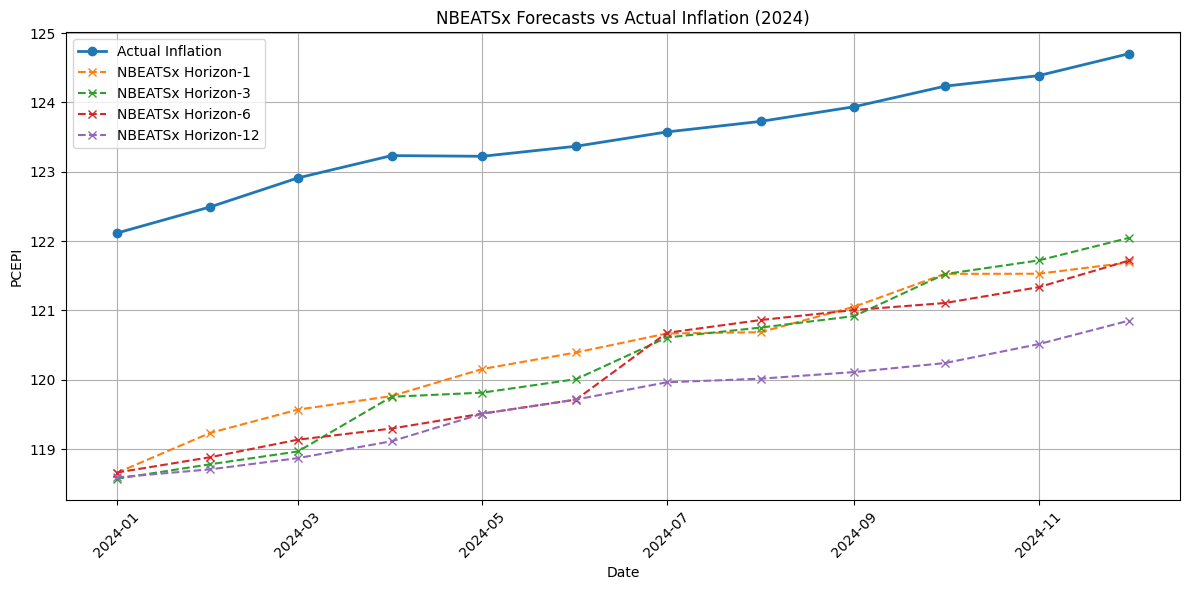

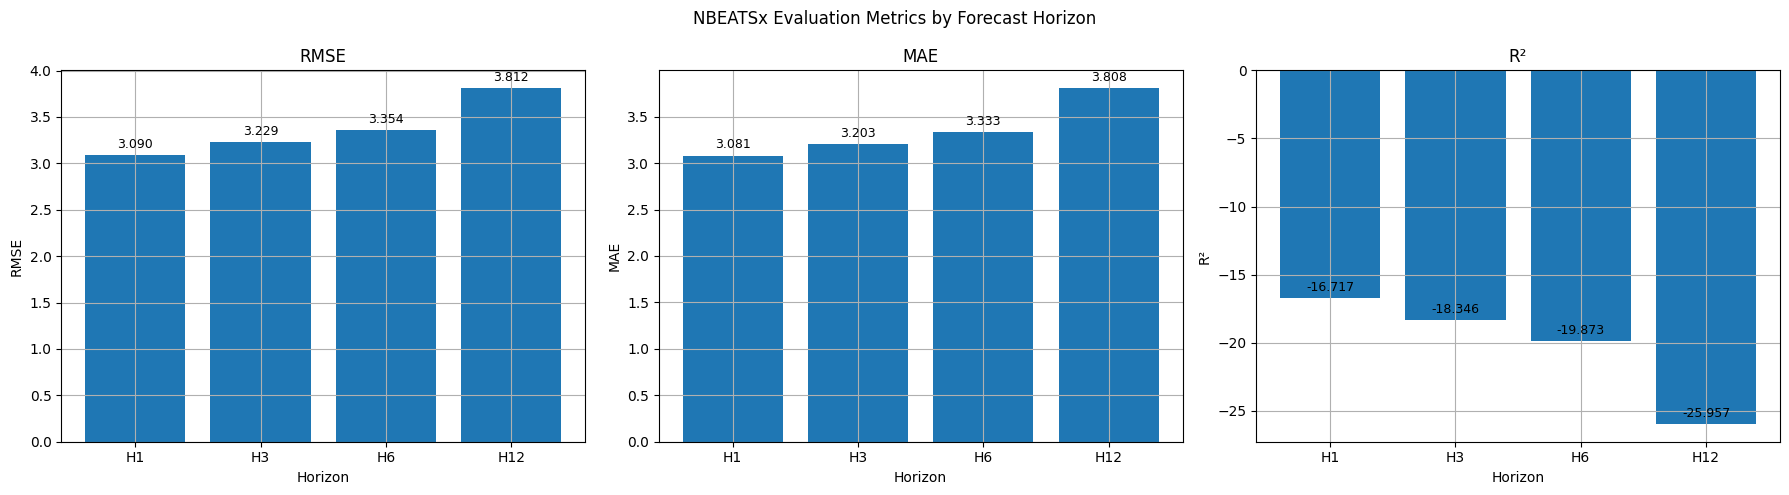

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CONFIG 
TEST_DATA_PATH = Path("../../Data/Test/test1990s.csv")
PREDICTIONS_DIR = Path("../../Predictions")
HORIZONS = [1, 3, 6, 12]
OUTPUT_PLOT = "nbeatsx_forecast_all_horizons.png"
OUTPUT_METRICS = "nbeatsx_metrics_barplot.png"

# Load ground truth
test_df = pd.read_csv(TEST_DATA_PATH)
test_df["ds"] = pd.to_datetime(test_df["observation_date"], format="%m/%Y")
test_df = test_df.rename(columns={"fred_PCEPI": "y_original"})
dates = test_df["ds"].values[-12:]
ground_truth = test_df["y_original"].values[-12:]

# Forecast plot
plt.figure(figsize=(12, 6))
plt.plot(dates, ground_truth, label="Actual Inflation", marker='o', linewidth=2)

results = {"Horizon": [], "RMSE": [], "MAE": [], "R²": []}

for H in HORIZONS:
    pred_path = PREDICTIONS_DIR / f"Horizon{H}" / f"NBEATSx_horizon_{H}.npy"
    preds = np.load(pred_path)[-12:]

    plt.plot(dates, preds, label=f"NBEATSx Horizon-{H}", linestyle='--', marker='x')

    rmse = np.sqrt(mean_squared_error(ground_truth, preds))
    mae = mean_absolute_error(ground_truth, preds)
    r2 = r2_score(ground_truth, preds)

    results["Horizon"].append(f"H{H}")
    results["RMSE"].append(rmse)
    results["MAE"].append(mae)
    results["R²"].append(r2)

plt.title("NBEATSx Forecasts vs Actual Inflation (2024)")
plt.xlabel("Date")
plt.ylabel("PCEPI")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_PLOT, dpi=300)
plt.show()

# Metrics bar chart with annotations
metrics_df = pd.DataFrame(results).set_index("Horizon")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(["RMSE", "MAE", "R²"]):
    ax = axs[i]
    bars = ax.bar(metrics_df.index, metrics_df[metric], color='tab:blue')
    ax.set_title(metric)
    ax.set_xlabel("Horizon")
    ax.set_ylabel(metric)
    ax.grid(True)
    
    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.3f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.suptitle("NBEATSx Evaluation Metrics by Forecast Horizon")
plt.tight_layout()
plt.savefig(OUTPUT_METRICS, dpi=300)
plt.show()